<a href="https://colab.research.google.com/github/buabaj/Notitia-Chat-Analysis/blob/master/whatsapp_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import re
import math
from collections import Counter
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_colwidth", 100)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
import matplotlib.ticker as mtick
rcParams['figure.figsize'] = (8, 3)
rcParams['figure.dpi'] = 150
rcParams['lines.linewidth'] = 2

import seaborn as sns
sns.set_style("darkgrid")

import plotly.express as px
import plotly.graph_objects as go

!pip install heatmapz


from heatmap import heatmap, corrplot # pip install heatmapz

from wordcloud import WordCloud

import ipywidgets as widgets
from IPython.display import display

from PIL import Image

In [ ]:
!pip install text_preprocessing
from helper import *
from text_preprocessing import *

In [ ]:
def startsWithDateAndTime(s):
    pattern = '^\[([0-9]+)([\/-])([0-9]+)([\/-])([0-9]+)[,]? ([0-9]+):([0-9][0-9]):([0-9][0-9])[ ]?(AM|PM|am|pm)?\]'
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [ ]:
startsWithDateAndTime('[12/02/2020, 7:02:58 PM] ACQU BENJAMIN: Me?')


True

In [ ]:
def FindAuthor(s):
    patterns = [
        '([\w]+):',                        # First Name
        '([\w]+[\s]+[\w]+):',              # First Name + Last Name
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',    # First Name + Middle Name + Last Name
        '([+]\d{2} \d{3} \d{3}):',         # Mobile Number (Ghana)
        '([\w]+)[\u263a-\U0001f999]+:',    # Name and Emoji              
    ]
    pattern = '^' + '|'.join(patterns)
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [ ]:
def getDataPoint(line):   
    splitLine = line.split('] ')
    dateTime = splitLine[0]
    if ',' in dateTime:
      date, time = dateTime.split(',') 
    else:
      date, time = dateTime.split(' ') 
    message = ' '.join(splitLine[1:])
    if FindAuthor(message): 
        splitMessage = message.split(': ') 
        author = splitMessage[0] 
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return date, time, author, message

In [ ]:
parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe
conversationPath = '_chat.txt' 
with open(conversationPath, encoding="utf-8") as fp:
    fp.readline() # Skipping first line of the file because contains information related to something about end-to-end encryption
    fp.readline()
    fp.readline()
    messageBuffer = [] 
    date, time, author = None, None, None
    while True:
        line = fp.readline()
        if not line: 
            break 
        line = line.strip()
        if startsWithDateAndTime(line): 
            if len(messageBuffer) > 0: 
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) 
            messageBuffer.clear() 
            date, time, author, message = getDataPoint(line) 
            messageBuffer.append(message) 
        else:
          line= (line.encode('ascii', 'ignore')).decode("utf-8")
          if startsWithDateAndTime(line): 
            if len(messageBuffer) > 0: 
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) 
            messageBuffer.clear() 
            date, time, author, message = getDataPoint(line) 
            messageBuffer.append(message) 
          else:
            messageBuffer.append(line)

In [ ]:
import datetime
def dateconv(date):
  year=''
  if '-' in date:
    year = date.split('-')[2]
    if len(year) == 4:
      return datetime.datetime.strptime(date, "[%d-%m-%Y").strftime("%Y-%m-%d")
    elif len(year) ==2:
      return datetime.datetime.strptime(date, "[%d-%m-%y").strftime("%Y-%m-%d")
  elif '/' in date:
    year = date.split('/')[2]
    if len(year) == 4:
      return datetime.datetime.strptime(date, "[%d/%m/%Y").strftime("%Y-%m-%d")
    if len(year) ==2:
      return datetime.datetime.strptime(date, "[%d/%m/%y").strftime("%Y-%m-%d")
df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message']) # Initialising a pandas Dataframe.
df["Date"] = df["Date"].apply(dateconv)
df["Date"] = pd.to_datetime(df["Date"])
df['Time'] = (pd.to_datetime(df["Time"].str.strip())).dt.time

In [ ]:
df

,Date,Time,Author,Message
0,2020-02-12,18:28:05,Bj,image omitted
1,2020-02-12,18:28:13,Bj,Thoughts guys??
2,2020-02-12,18:28:21,Bj,Together as a team
3,2020-02-12,18:28:57,Labs,Ok
4,2020-02-12,18:29:07,Bj,Cool
...,...,...,...,...
6472,2020-08-21,11:26:26,Bj,sure
6473,2020-08-21,11:26:30,Labs,how you go do ham
6474,2020-08-21,11:27:14,Bj,i no know how edey on ios but check the 3 dots at the top right corner
6475,2020-08-21,11:41:02,Labs,adey use web


In [ ]:
# a. Chat
df = df[~df["Author"].isnull()].reset_index(drop=True)
# b. Activities (Subject change, group icon change, left, added)
activity_df = df[df["Author"].isnull()]

In [ ]:
df

,Date,Time,Author,Message
0,2020-02-12,18:28:05,Bj,image omitted
1,2020-02-12,18:28:13,Bj,Thoughts guys??
2,2020-02-12,18:28:21,Bj,Together as a team
3,2020-02-12,18:28:57,Labs,Ok
4,2020-02-12,18:29:07,Bj,Cool
...,...,...,...,...
6470,2020-08-21,11:26:26,Bj,sure
6471,2020-08-21,11:26:30,Labs,how you go do ham
6472,2020-08-21,11:27:14,Bj,i no know how edey on ios but check the 3 dots at the top right corner
6473,2020-08-21,11:41:02,Labs,adey use web


In [ ]:
total_messages = df.shape[0]
number_of_days = (df["Date"].max() - df["Date"].min()).days + 1

print ("{:<32}: {}".format("Group formed", df["Date"].min().date()))
print ("{:<32}: {}".format("Total Authors", df["Author"].nunique()))
print ("{:<32}: {}".format("Total messages", total_messages))
print ("{:<32}: {}".format("Number of days", number_of_days))
print ("{:<32}: {}".format("Avg. messages sent every day", round(total_messages/number_of_days, 2)))

Group formed                    : 2020-02-12
Total Authors                   : 4
Total messages                  : 6475
Number of days                  : 192
Avg. messages sent every day    : 33.72


In [ ]:
date_df = df.copy()

# enriching
## 1. year
date_df["year"] = date_df["Date"].apply(lambda x: x.year)

## 2. month
date_df["month"] = date_df["Date"].apply(lambda x: x.strftime("%b"))
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
date_df['month'] = pd.Categorical(date_df['month'], months)

## 3. day_of_week
date_df["day_of_week"] = date_df["Date"].apply(lambda x: x.strftime('%a'))
day_of_week = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
date_df['day_of_week'] = pd.Categorical(date_df['day_of_week'], day_of_week)

In [ ]:
date_df.head(2)


,Date,Time,Author,Message,year,month,day_of_week
0,2020-02-12,18:28:05,Bj,image omitted,2020,Feb,Wed
1,2020-02-12,18:28:13,Bj,Thoughts guys??,2020,Feb,Wed


In [ ]:
analysis_df = date_df.groupby(["year", "month"], as_index=False, sort=[True, True])["Message"].count()
analysis_df = analysis_df[~analysis_df["Message"].isnull()]
analysis_df["month_year"] = analysis_df.apply(lambda x: x["month"] + " " + str(x["year"]), axis=1)

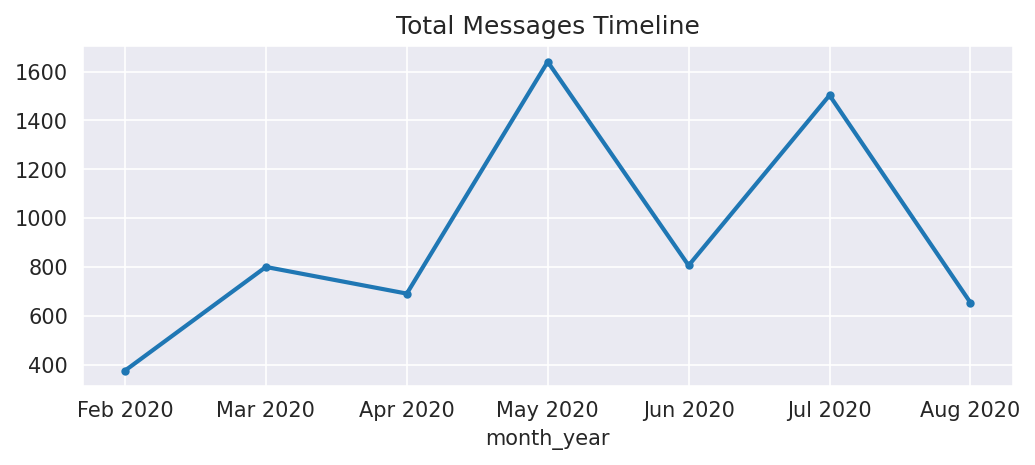

In [ ]:
## plot 1
analysis_df.set_index("month_year")["Message"].plot(style='.-', figsize=(8, 3), title="Total Messages Timeline")


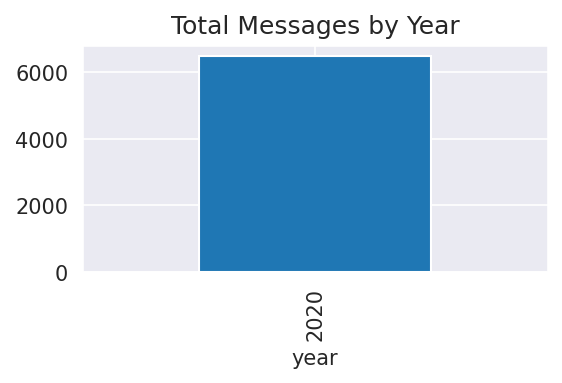

In [ ]:
## plot 2
analysis_df.groupby("year")["Message"].sum().plot(kind='bar', figsize=(4, 2), title="Total Messages by Year")



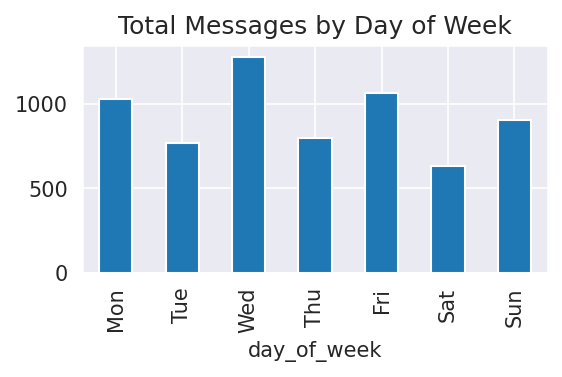

In [ ]:
## plot 3
date_df.groupby('day_of_week', sort=[True])["Message"].count().plot(kind='bar', figsize=(4, 2), title="Total Messages by Day of Week")


In [ ]:
time_df = df.copy()
   
  

# enriching
# 1. hour
time_df["hour"] = time_df["Time"].apply(lambda x: x.hour)

# 2. day_of_week
time_df["day_of_week"] = time_df["Date"].apply(lambda x: x.strftime('%a'))
day_of_week = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
time_df['day_of_week'] = pd.Categorical(time_df['day_of_week'], day_of_week)


# 3. part_of_day
time_df["part_of_day"] = time_df["hour"].apply(lambda x: part_of_day(x))
# time_df["part_of_day"]






NameError: ignored